In [24]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, CausalForestDML

# Helper imports
import numpy as np
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV, LinearRegression,
                                  MultiTaskElasticNet, MultiTaskElasticNetCV)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
import geopandas as gpd
import pandas as pd

from sklearn.model_selection import train_test_split
%matplotlib inline

In [25]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
ox.config(use_cache=True, log_console=False)

In [26]:
src = rasterio.open('LongNTL_2020.tif')

In [27]:
data = pd.read_csv("./LightPollution/LosAngeles_final.csv")
data = gpd.GeoDataFrame(
    data.loc[:, [c for c in data.columns if c != "geometry"]],
    geometry = gpd.GeoSeries.from_wkt(data["geometry"]),
    crs="EPSG:4326")
data.drop(["Unnamed: 0"], axis = 1, inplace = True)
data

,highway,railway,source,source_ref,landuse,man_made,name,barrier,addr:county,addr:postcode,...,industrial_mean_NTL,residential_mean_distance,residential_mean_NTL,retail_mean_distance,retail_mean_NTL,Over_illumination,Trespass,Clutter,residential,geometry
0,0,0,0,0,residential,0,0,0,0,0,...,86.100000,1638.130322,95.566364,1293.680846,71.707223,3950.175008,0.553910,0.004854,11.0,POINT (-118.19454 33.78358)
1,0,0,0,0,residential,0,Sovereign,0,0,0,...,132.468333,732.157837,101.877500,1866.684569,71.707223,4228.625008,0.842114,0.011232,10.0,POINT (-118.19583 33.76681)
2,0,0,0,0,residential,0,Gallery 421 Apartments,0,0,0,...,119.878750,706.487893,101.877500,1688.259567,71.707223,4521.950005,0.876978,0.011028,10.0,POINT (-118.19592 33.76950)
3,0,0,0,0,residential,0,Sea Spray Apartments,0,0,0,...,119.878750,716.013825,101.877500,1707.081687,71.707223,4407.470009,0.000000,0.000000,10.0,POINT (-118.19621 33.76947)
4,0,0,0,0,residential,0,JJL,0,0,0,...,153.657500,792.150771,101.877500,1730.059709,67.542274,4344.465008,0.000000,0.000000,10.0,POINT (-118.18901 33.76752)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5865,0,0,0,0,residential,0,0,0,0,0,...,NaN,1127.161601,2.912143,NaN,NaN,20.385000,0.003124,0.000258,7.0,"POLYGON ((-118.59646 34.12314, -118.59594 34.1..."
5866,0,0,0,0,residential,0,0,0,0,0,...,NaN,1209.533680,7.808001,2226.391962,18.615002,981.270017,0.106376,0.000234,5.0,"POLYGON ((-118.60090 34.13903, -118.60091 34.1..."
5867,0,0,0,0,residential,0,0,0,0,0,...,NaN,999.680631,9.171251,1496.189914,16.692501,1528.330020,0.224907,0.000676,4.0,"POLYGON ((-118.60560 34.14339, -118.60448 34.1..."
5868,0,0,0,0,residential,0,0,0,0,0,...,NaN,1293.681549,2.385500,1806.378663,3.216667,33.505000,0.004885,0.000158,10.0,"POLYGON ((-118.59821 34.09961, -118.59802 34.0..."


In [28]:
features = ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL',
            'commercial', 'commercial_mean_distance', 'commercial_mean_NTL',
            'construction', 'construction_mean_distance', 'construction_mean_NTL',
            'farmland', 'farmland_mean_distance', 'farmland_mean_NTL',
            'forest', 'forest_mean_distance', 'forest_mean_NTL', 
            'grass',  'grass_mean_distance', 'grass_mean_NTL',
            'industrial', 'industrial_mean_distance', 'industrial_mean_NTL',
            'residential', 'residential_mean_distance', 'residential_mean_NTL', 
            'retail', 'retail_mean_distance', 'retail_mean_NTL']
len(features)

27

In [29]:
mean_val = data.mean()
data = data.fillna(mean_val)

In [30]:
data["Over_illumination"] = (data["Over_illumination"] - data["Over_illumination"].min()) / (data["Over_illumination"].max() - data["Over_illumination"].min())
data["Trespass"] = (data["Trespass"] - data["Trespass"].min()) / (data["Trespass"].max() - data["Trespass"].min())
data["Clutter"] = (data["Clutter"] - data["Clutter"].min()) / (data["Clutter"].max() - data["Clutter"].min())

In [31]:
data[["Over_illumination", "Trespass", "Clutter"]]

,Over_illumination,Trespass,Clutter
0,0.065354,0.101555,0.432189
1,0.069961,0.154394,1.000000
2,0.074814,0.160786,0.981880
3,0.072920,0.000000,0.000000
4,0.071877,0.000000,0.000000
...,...,...,...
5865,0.000337,0.000573,0.022995
5866,0.016235,0.019503,0.020871
5867,0.025286,0.041235,0.060184
5868,0.000554,0.000896,0.014034


In [32]:
from sklearn.preprocessing import MinMaxScaler

In [33]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['residential', 'residential_mean_distance', 'residential_mean_NTL']]].values)
T = scaler.fit_transform(data[['residential', 'residential_mean_distance', 'residential_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary.reset_index(inplace=True)

Summary["Treatment"] = "residential"

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.422,0.012,34.327,0.000,0.402,0.443,residential
1,0,Y1,0.014,0.021,0.662,0.508,-0.021,0.048,residential
2,0,Y2,0.008,0.020,0.395,0.693,-0.025,0.040,residential


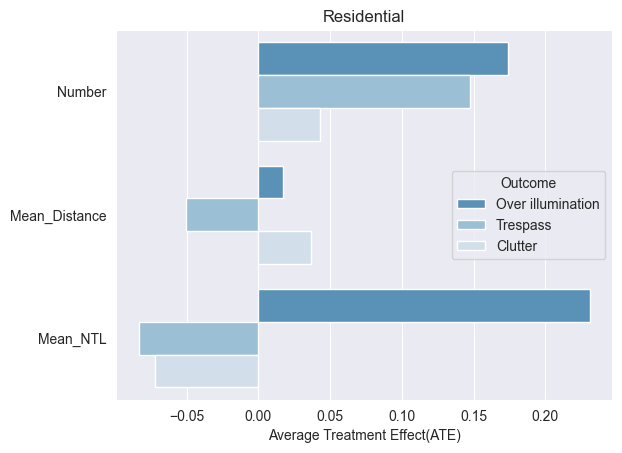

In [34]:
residential_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
residential_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
residential_effect = pd.melt(residential_effect, id_vars=["Treatment"], var_name = "Outcome")
residential_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = residential_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)
g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Residential")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("residential5.svg", bbox_inches = "tight")

In [35]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']]].values)
T = scaler.fit_transform(data[['commercial', 'commercial_mean_distance', 'commercial_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary.reset_index(inplace=True)

summary["Treatment"] = "commercial"
summary
Summary = pd.concat([Summary, summary], axis = 0)

Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.422,0.012,34.327,0.000,0.402,0.443,residential
1,0,Y1,0.014,0.021,0.662,0.508,-0.021,0.048,residential
2,0,Y2,0.008,0.020,0.395,0.693,-0.025,0.040,residential
0,0,Y0,0.145,0.008,18.769,0.000,0.132,0.158,commercial
1,0,Y1,0.331,0.030,10.964,0.000,0.281,0.381,commercial
2,0,Y2,0.091,0.016,5.762,0.000,0.065,0.116,commercial


In [36]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['retail', 'retail_mean_distance', 'retail_mean_NTL']]].values)
T = scaler.fit_transform(data[['retail', 'retail_mean_distance', 'retail_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "retail"
Summary = pd.concat([Summary, summary], axis = 0)
Summary

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.422,0.012,34.327,0.000,0.402,0.443,residential
1,0,Y1,0.014,0.021,0.662,0.508,-0.021,0.048,residential
2,0,Y2,0.008,0.020,0.395,0.693,-0.025,0.040,residential
0,0,Y0,0.145,0.008,18.769,0.000,0.132,0.158,commercial
1,0,Y1,0.331,0.030,10.964,0.000,0.281,0.381,commercial
2,0,Y2,0.091,0.016,5.762,0.000,0.065,0.116,commercial
0,0,Y0,0.110,0.008,13.903,0.000,0.097,0.123,retail
1,0,Y1,0.075,0.023,3.217,0.001,0.037,0.113,retail
2,0,Y2,0.084,0.021,4.085,0.000,0.050,0.117,retail


In [37]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']]].values)
T = scaler.fit_transform(data[['brownfield', 'brownfield_mean_distance', 'brownfield_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary2 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary2.reset_index(inplace=True)

Summary2["Treatment"] = "brownfield"
# Summary = pd.concat([Summary, summary], axis = 0)

Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.113,0.009,12.243,0.000,0.098,0.128,brownfield
1,0,Y1,0.173,0.040,4.366,0.000,0.108,0.239,brownfield
2,0,Y2,0.048,0.022,2.183,0.029,0.012,0.084,brownfield


In [38]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['construction', 'construction_mean_distance', 'construction_mean_NTL',]]].values)
T = scaler.fit_transform(data[['construction', 'construction_mean_distance', 'construction_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "construction"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.113,0.009,12.243,0.000,0.098,0.128,brownfield
1,0,Y1,0.173,0.040,4.366,0.000,0.108,0.239,brownfield
2,0,Y2,0.048,0.022,2.183,0.029,0.012,0.084,brownfield
0,0,Y0,0.050,0.009,5.711,0.000,0.036,0.065,construction
1,0,Y1,-0.321,0.034,-9.392,0.000,-0.377,-0.264,construction
2,0,Y2,-0.146,0.022,-6.639,0.000,-0.182,-0.109,construction


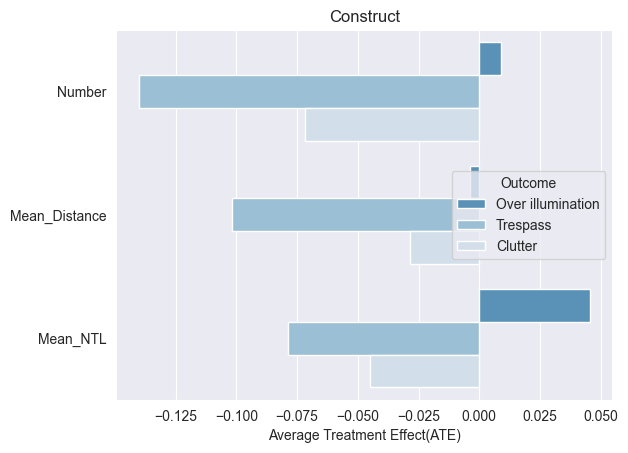

In [39]:
construct_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
construct_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
construct_effect = pd.melt(construct_effect, id_vars=["Treatment"], var_name = "Outcome")
construct_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = construct_effect,
    y="Treatment", x="value", hue="Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title="Construct")
plt.legend(title = "Outcome", loc="center right")
plt.savefig("construct3.svg", bbox_inches = "tight")

In [40]:
scaler = MinMaxScaler()

W = scaler.fit_transform(data[[c for c in features if c not in ['industrial', 'industrial_mean_distance', 'industrial_mean_NTL']]].values)
T = scaler.fit_transform(data[['industrial', 'industrial_mean_distance', 'industrial_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "industrial"
Summary2 = pd.concat([Summary2, summary], axis = 0)
Summary2

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.113,0.009,12.243,0.000,0.098,0.128,brownfield
1,0,Y1,0.173,0.040,4.366,0.000,0.108,0.239,brownfield
2,0,Y2,0.048,0.022,2.183,0.029,0.012,0.084,brownfield
0,0,Y0,0.050,0.009,5.711,0.000,0.036,0.065,construction
1,0,Y1,-0.321,0.034,-9.392,0.000,-0.377,-0.264,construction
2,0,Y2,-0.146,0.022,-6.639,0.000,-0.182,-0.109,construction
0,0,Y0,0.052,0.005,10.023,0.000,0.044,0.061,industrial
1,0,Y1,-0.151,0.022,-6.962,0.000,-0.187,-0.115,industrial
2,0,Y2,-0.069,0.014,-4.941,0.000,-0.092,-0.046,industrial


In [41]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['grass', 'grass_mean_distance', 'grass_mean_NTL']]].values)
T = scaler.fit_transform(data[['grass', 'grass_mean_distance', 'grass_mean_NTL']].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)
est.fit(Y, T, W = W)

est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)

Summary3 = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
Summary3.reset_index(inplace=True)

Summary3["Treatment"] = "grass"
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.909,0.020,44.537,0.000,0.875,0.943,grass
1,0,Y1,-0.061,0.023,-2.665,0.008,-0.098,-0.023,grass
2,0,Y2,-0.066,0.015,-4.329,0.000,-0.092,-0.041,grass


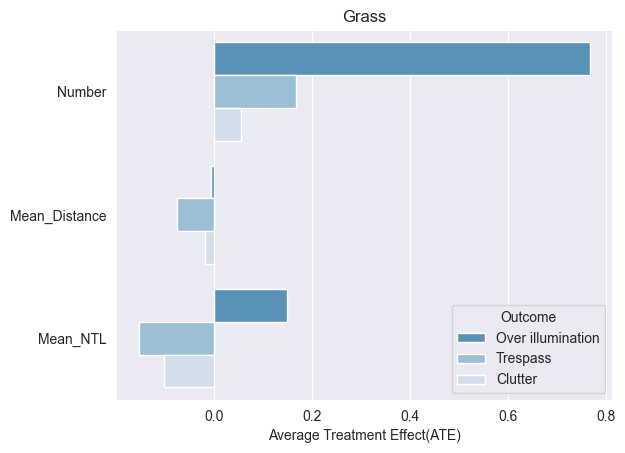

In [42]:
grass_effect = pd.DataFrame(est.const_marginal_ate().T, columns = ["Over illumination", "Trespass", "Clutter"])
grass_effect["Treatment"] = ["Number", "Mean_Distance", "Mean_NTL"]
grass_effect = pd.melt(grass_effect, id_vars=["Treatment"], var_name = "Outcome")
grass_effect

sns.set_style("darkgrid")

flatui = ["#4995C6", "#92C2DD", "#CEDFEF"]
sns.set_palette(flatui)

g = sns.barplot(
    data = grass_effect,
    y = "Treatment", x = "value", hue = "Outcome", palette = sns.color_palette(), alpha = 1,
    orient='h'
)

g.set(ylabel='', xlabel = "Average Treatment Effect(ATE)", title = "Grass")
plt.savefig("grass5.svg", bbox_inches = "tight")

In [43]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['farmland', 'farmland_mean_distance', 'farmland_mean_NTL']]].values)
T = scaler.fit_transform(data[['farmland', 'farmland_mean_distance', 'farmland_mean_NTL',]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                model_t = MultiTaskElasticNetCV(cv = 3, max_iter = 2000),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "farmland"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.909,0.020,44.537,0.000,0.875,0.943,grass
1,0,Y1,-0.061,0.023,-2.665,0.008,-0.098,-0.023,grass
2,0,Y2,-0.066,0.015,-4.329,0.000,-0.092,-0.041,grass
0,0,Y0,-0.027,0.008,-3.432,0.001,-0.040,-0.014,farmland
1,0,Y1,-0.008,0.040,-0.198,0.843,-0.074,0.058,farmland
2,0,Y2,0.103,0.039,2.658,0.008,0.039,0.167,farmland


In [44]:
scaler = MinMaxScaler()
W = scaler.fit_transform(data[[c for c in features if c not in ['forest', 'forest_mean_distance', 'forest_mean_NTL']]].values)
T = scaler.fit_transform(data[['forest', 'forest_mean_distance', 'forest_mean_NTL', ]].values)
Y = data[["Over_illumination", "Trespass", "Clutter"]].values

est = LinearDML(model_y = MultiTaskElasticNetCV(cv = 3, tol = 1),
                model_t = MultiTaskElasticNetCV(cv = 3),
                linear_first_stages = True)

est.fit(Y, T, W = W)
est.effect_inference().population_summary(alpha = 0.1, value = 0, decimals = 3, tol = 0.001)

summary = est.effect_inference().summary_frame(alpha = 0.1, value = 0, decimals = 3)
summary = summary.reset_index()

summary["Treatment"] = "forest"
Summary3 = pd.concat([Summary3, summary], axis = 0)
Summary3

,X,Y,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper,Treatment
0,0,Y0,0.909,0.020,44.537,0.000,0.875,0.943,grass
1,0,Y1,-0.061,0.023,-2.665,0.008,-0.098,-0.023,grass
2,0,Y2,-0.066,0.015,-4.329,0.000,-0.092,-0.041,grass
0,0,Y0,-0.027,0.008,-3.432,0.001,-0.040,-0.014,farmland
1,0,Y1,-0.008,0.040,-0.198,0.843,-0.074,0.058,farmland
2,0,Y2,0.103,0.039,2.658,0.008,0.039,0.167,farmland
0,0,Y0,0.026,0.009,2.975,0.003,0.011,0.040,forest
1,0,Y1,0.030,0.028,1.081,0.280,-0.016,0.076,forest
2,0,Y2,0.068,0.018,3.785,0.000,0.038,0.098,forest


In [45]:
Summary.loc[Summary["Y"]=="Y0", "Y"] = "Over Illumination"
Summary.loc[Summary["Y"]=="Y1", "Y"] = "Trespass"
Summary.loc[Summary["Y"]=="Y2", "Y"] = "Clutter"

Summary.rename(columns={"Y": "Outcome"}, inplace = True)

In [46]:
Summary2.loc[Summary2["Y"]=="Y0", "Y"] = "Over Illumination"
Summary2.loc[Summary2["Y"]=="Y1", "Y"] = "Trespass"
Summary2.loc[Summary2["Y"]=="Y2", "Y"] = "Clutter"

Summary2.rename(columns={"Y": "Outcome"}, inplace = True)

In [47]:
Summary3.loc[Summary3["Y"]=="Y0", "Y"] = "Over Illumination"
Summary3.loc[Summary3["Y"]=="Y1", "Y"] = "Trespass"
Summary3.loc[Summary3["Y"]=="Y2", "Y"] = "Clutter"

Summary3.rename(columns = {"Y": "Outcome"}, inplace = True)

In [48]:
Summarys = [Summary, Summary2, Summary3]

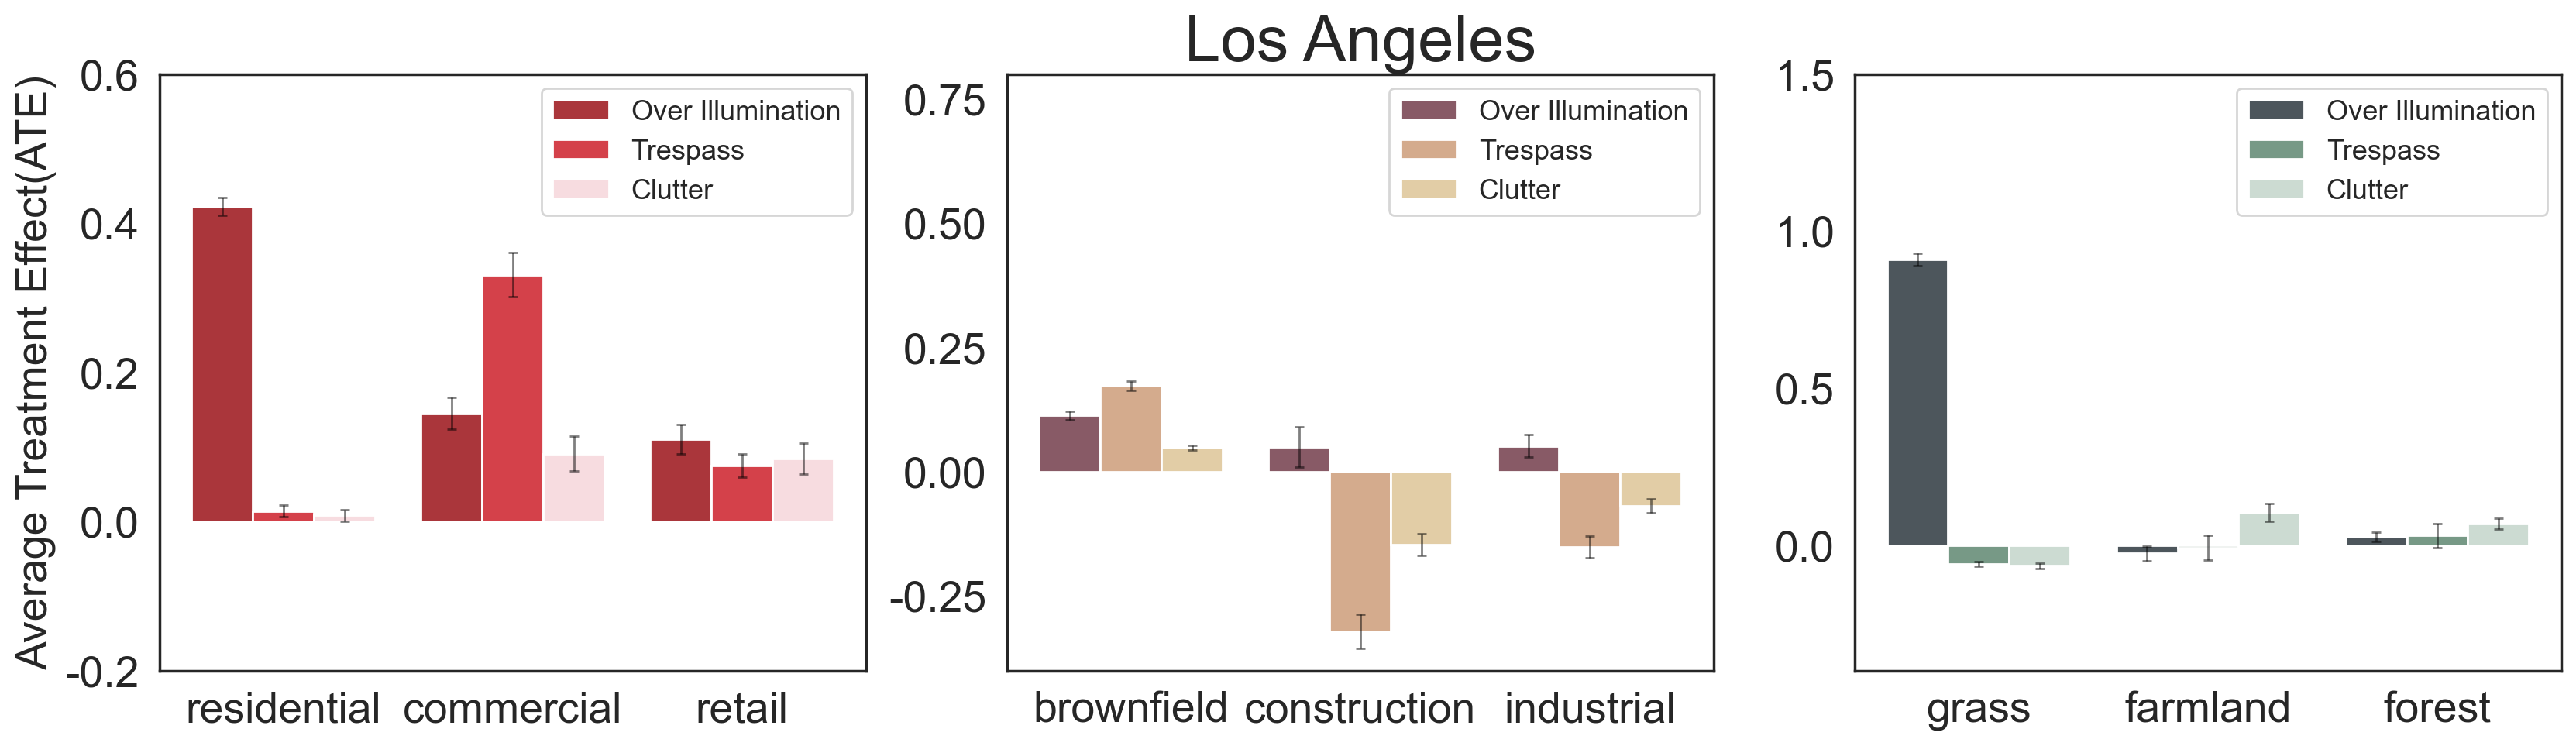

In [57]:
import pandas as pd
import seaborn as sns


# plt.figure(figsize = (20, 5))
sns.set_style("white")

fig, axes = plt.subplots(1, 3, figsize=(20, 5))

flatui = ["#BD2329", "#EC2835", "#FCD7DD"]
sns.set_palette(flatui)

sns.barplot(
    data = Summary,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[0]
)

flatui = ["#8f5362", "#e0a981", "#ecd09c"]
sns.set_palette(flatui)

axes[1] = sns.barplot(
    data = Summary2,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[1]
)

# flatui = ["#79b4a0", "#a3c8a4", "#d4daa1"]
# sns.set_palette(flatui)

flatui = ["#4A565F", "#719F85", "#CADDD1"]
sns.set_palette(flatui)

axes[2] = sns.barplot(
    data = Summary3,
    x = "Treatment", y = "point_estimate", hue = "Outcome", palette = sns.color_palette(), alpha = 1, ax = axes[2]
)

for index in range(3):
    x = Summarys[index]["Treatment"]
    y = Summarys[index]["point_estimate"]
    yerr = Summarys[index]["stderr"]
    
    bars = [c for c in axes[index].get_children() if isinstance(c, matplotlib.patches.Rectangle)]
    bars = bars[:-1]
    
    for i, bar in enumerate(bars):
            height = bar.get_height()
            x_pos = bar.get_x() + bar.get_width() / 2
            axes[index].errorbar(x = x_pos, y = height, yerr = yerr.iloc[i], fmt = 'none', capsize = 2, color = 'black', elinewidth = 1, alpha = 0.5)

# plt.savefig("ATE2.svg", bbox_inches = "tight")
axes[0].set(xlabel = '')
axes[0].set_ylabel(ylabel = "Average Treatment Effect(ATE)", fontsize = 20)

# axes[0].legend().set_visible(False)
# axes[1].legend().set_visible(False)

axes[1].set(xlabel = '', ylabel = "")
axes[1].set_ylim([-0.4, 0.8])
axes[0].set_ylim([-0.2, 0.6])
axes[1].set_title("Los Angeles", fontsize = 30)
axes[2].set_ylim([-0.4, 1.5])
axes[2].set(xlabel = '', ylabel = "")
axes[0].legend(fontsize = 13)
axes[1].legend(fontsize = 13)
axes[2].legend(fontsize = 13)
axes[0].tick_params(axis='both', which='major', labelsize=20)
axes[1].tick_params(axis='both', which='major', labelsize=20)
axes[2].tick_params(axis='both', which='major', labelsize=20)

plt.savefig("ATE_LA.svg", bbox_inches = "tight")